# Analysis of the deformation in linescan measurements by image registration

#To do : 

- Extract deformation of vessels and endfoot from the different channels
- Compare with traces
- Extract ridig motion layer 2 form the interfaces
- Extract rigid motion form traces
- peak to peak analysis rigid motion
- peak to peak analysis deformation
- comparison artifact rigid motion
- comparison PVS1 PVS2


## Import libraries

In [1]:
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

import numpy as np

In [3]:
import SimpleITK as sitk
print(sitk.Version())

image_viewer = sitk.ImageViewer()
image_viewer.SetCommand('/home/alexandra/Slicer-4.11.20210226-linux-amd64/Slicer')

SimpleITK Version: 2.0.0rc2 (ITK 5.1)
Compiled: Jun 30 2020 13:57:21



In [4]:
import sys
sys.path.append("../") # go to parent dir
from src.datanalysis import lowpassfilter, highpassfilter

In [5]:
from scipy.signal import savgol_filter

## Import data

In [6]:
Files={}

Files['WT06']={}
Files['WT09']={}
Files['WT10']={}

Files['WT06']['name']='WT-06-11-047'
Files['WT09']['name']='WT-09-03-073'
Files['WT10']['name']='WT-10-07-093'

Files['WT06']['traces']='/home/alexandra/Documents/Data/Laura/Linescans/270122_4traces/PenetratingArterioles/WT 06 20201008 09 Penetrating Arteriole 045.csv'
Files['WT09']['traces']='/home/alexandra/Documents/Data/Laura/Linescans/270122_4traces/PenetratingArterioles/WT 09 20210308 03 Penetrating Arteriole 073.csv'
Files['WT10']['traces']='/home/alexandra/Documents/Data/Laura/Linescans/270122_4traces/PenetratingArterioles/WT 10 20210226 07 Penetrating Arteriole 093.csv'

Files['WT06']['info']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 06 20201008 09 Penetrating Arteriole 045 info.csv'
Files['WT09']['info']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 09 20210308 03 Penetrating Arteriole 073 info.csv'
Files['WT10']['info']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 10 20210226 07 Penetrating Arteriole 093 info.csv'

Files['WT06']['red']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 06 20201008 09 Penetrating Arteriole 045 lumen.tif'
Files['WT09']['red']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 09 20210308 03 Penetrating Arteriole 073 lumen.tif'
Files['WT10']['red']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 10 20210226 07 Penetrating Arteriole 093 lumen.tif'

Files['WT06']['green']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 06 20201008 09 Penetrating Arteriole 045 endfoot.tif'
Files['WT09']['green']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 09 20210308 03 Penetrating Arteriole 073 endfoot.tif'
Files['WT10']['green']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 10 20210226 07 Penetrating Arteriole 093 endfoot.tif'

In [7]:
# bad correlation lumen
Files={}
Files['WT08']={}
Files['WT08']['tini']=120
Files['WT08']['name']='WT-08-03-064'
Files['WT08']['traces']='/home/alexandra/Documents/Data/Laura/Linescans/270122_4traces/PenetratingArterioles/WT 08 20210309 03 Penetrating Arteriole 064.csv'
Files['WT08']['info']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 08 20210309 03 Penetrating Arteriole 064 info.csv'
Files['WT08']['red']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 08 20210309 03 Penetrating Arteriole 064 lumen.tif'
Files['WT08']['green']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 08 20210309 03 Penetrating Arteriole 064 endfoot.tif'

In [8]:
#high amplitude VLF lumen
Files={}
Files['WT10']={}
Files['WT10']['tini']=462
Files['WT10']['name']='WT-10-05-105'
Files['WT10']['traces']='/home/alexandra/Documents/Data/Laura/Linescans/270122_4traces/PenetratingArterioles/WT 10 20210422 05 Penetrating Arteriole 105.csv'
Files['WT10']['info']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 10 20210422 05 Penetrating Arteriole 105 info.csv'
Files['WT10']['red']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 10 20210422 05 Penetrating Arteriole 105 lumen.tif'
Files['WT10']['green']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 10 20210422 05 Penetrating Arteriole 105 endfoot.tif'

In [9]:
# high amplitude PVS
Files={}
Files['WT06']={}
Files['WT06']['name']='WT-06-09-045'
Files['WT05']['tini']=163
Files['WT06']['traces']='/home/alexandra/Documents/Data/Laura/Linescans/270122_4traces/PenetratingArterioles/WT 06 20201008 09 Penetrating Arteriole 045.csv'
Files['WT06']['info']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 06 20201008 09 Penetrating Arteriole 045 info.csv'
Files['WT06']['red']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 06 20201008 09 Penetrating Arteriole 045 lumen.tif'
Files['WT06']['green']='/home/alexandra/Documents/Data/Laura/Linescans/raw_images/WT 06 20201008 09 Penetrating Arteriole 045 endfoot.tif'

Files['WT09']={}
Files['WT09']['name']='WT-09-04-074'

KeyError: 'WT05'

In [7]:
mouse='WT06'
# initial time and time window
#tini=Files[mouse]['tini'] #sec
tini=638
#09 04  t  480
timewindow=3 #sec

outputfolder='output/'+mouse+'/'+str(int(tini))+'/'

import os
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

In [8]:
# previoulsy analysed peak to peak 

peaktopeakPVS1=pd.read_pickle('/home/alexandra/Documents/Python/linescan-analysis/output/databases/PenetratingArteriolesWT5/PenetratingArteriolesWT5_'+Files[mouse]['name']+'-PVS1.pkl')
peaktopeakPVS2=pd.read_pickle('/home/alexandra/Documents/Python/linescan-analysis/output/databases/PenetratingArteriolesWT5/PenetratingArteriolesWT5_'+Files[mouse]['name']+'-PVS2.pkl')
peaktopeakLumen=pd.read_pickle('/home/alexandra/Documents/Python/linescan-analysis/output/databases/PenetratingArteriolesWT5/PenetratingArteriolesWT5_'+Files[mouse]['name']+'-lumen.pkl')

In [9]:
# previously analysed interface location 
data=pd.read_csv(Files[mouse]['traces'], decimal='.', delimiter=",")

In [10]:
# raw data
tiffgreen = sitk.ReadImage(Files[mouse]['green'])
tiffred = sitk.ReadImage(Files[mouse]['red'])

Arraygreen=sitk.GetArrayFromImage(tiffgreen)
Arrayred=sitk.GetArrayFromImage(tiffred)

In [11]:
info=pd.read_csv(Files[mouse]['info'], decimal='.', delimiter=",")

fs=info['vessel_fs'].values[0]
ts=1/fs
dx=info['vessel_dx'].values[0]

In [12]:
#number of pixels
Nx=len(Arrayred[:,0])

In [13]:
# time vector
spantime=np.arange(len(data))*ts

## Selection of time window of interest

In [14]:
peaktopeak=peaktopeakLumen

iscardiac=peaktopeak['bandname']=='cardiac'
highamp=(peaktopeak['amp']/peaktopeak['mean']>0.08)
peaktopeak[iscardiac&highamp]['tmin']

1700    385.885177
2767    420.284057
2785    422.196439
Name: tmin, dtype: float64

In [15]:
tini_index=np.where(spantime>=tini)[0][0]
Ntime=round(timewindow*fs)
tend_index=tini_index+Ntime

In [16]:
initialtraces={}

initialtraces['endfoot_bottom']=data['endfoot_lower'][tini_index:tend_index]
initialtraces['lumen_bottom']=data['lumen_lower'][tini_index:tend_index]
initialtraces['endfoot_top']=data['endfoot_upper'][tini_index:tend_index]
initialtraces['lumen_top']=data['lumen_upper'][tini_index:tend_index]

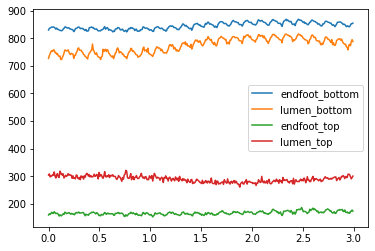

In [17]:
for label in initialtraces :
    plt.plot(np.arange(Ntime)*ts,np.array(initialtraces[label])/dx,label=label)
    
plt.legend()

## Define useful functions for registration analysis

In [18]:
sitk.ProcessObject.SetGlobalWarningDisplay(False)

In [19]:
import registration_callbacks

In [20]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda =  sitk.GetArrayFromImage(img)

    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
   # figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(title) #, figsize=figsize, dpi=dpi)
    #ax = fig.add_axes()
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    #extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    
    t = ax.imshow(nda,
            #extent=extent,
            interpolation='hamming',
            cmap='gray',
            origin='lower',
            aspect=2)
    
    if(title):
        plt.title(title)

In [21]:
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

In [22]:
def get_deformation(image, transform):
    x, y = image.GetSize()
    X, Y = np.meshgrid(np.arange(0, x, 1), np.arange(0, y, 1))
    
    U = np.zeros(X.shape)
    V = np.zeros(Y.shape)
    for index, value in np.ndenumerate(X):
        px, py = transform.TransformPoint((float(value), float(Y[index])))
        U[index] = px - value
        V[index] = py - Y[index]
    
    return U,V

## Visualise the two channels

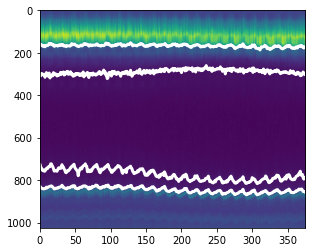

In [23]:
image2Dgreen=np.array(Arraygreen[:,tini_index:tend_index])
plt.imshow(image2Dgreen,aspect=0.3)

for label in initialtraces :
    plt.plot(np.arange(Ntime),np.array(initialtraces[label])/dx,label=label,linewidth=3,c='w')

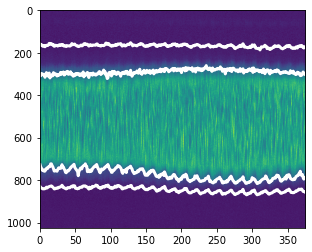

In [24]:
image2Dred=np.array(Arrayred[:,tini_index:tend_index])
plt.imshow(image2Dred,aspect=0.3)

for label in initialtraces :
    plt.plot(np.arange(Ntime),np.array(initialtraces[label])/dx,label=label,linewidth=3,c='w')

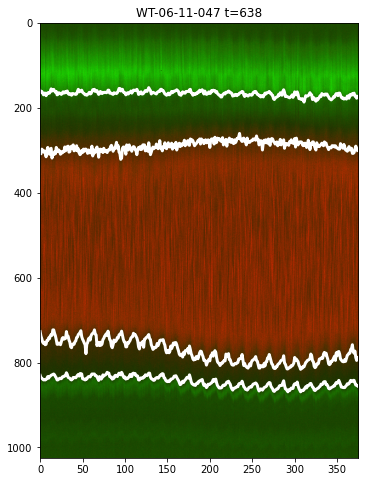

In [25]:
image2DRGB=np.zeros((np.size(image2Dgreen,0),np.size(image2Dgreen,1),3),'uint8')
image2DRGB[...,0]=image2Dred/image2Dred.max()*256
image2DRGB[...,1]=image2Dgreen/image2Dgreen.max()*256
image2DRGB=image2DRGB.astype('float32')
plt.figure(figsize=(8,8))
plt.imshow(image2DRGB/300,aspect=0.5)

for label in initialtraces :
    plt.plot(np.arange(Ntime),np.array(initialtraces[label])/dx,label=label,linewidth=3,c='w')

plt.title(Files[mouse]['name']+' t='+str(tini))
plt.savefig(outputfolder+'traces.png')

In [26]:
# Localisation of the markers in the initial frame
deltax=5
shift=2

ranges={}
upper={}
lower={}

upper['endfoot_bottom']=shift+30+5
lower['endfoot_bottom']=shift+5

upper['endfoot_top']=0
lower['endfoot_top']=-30

upper['lumen_bottom']=shift+10+10
lower['lumen_bottom']=shift+10

upper['lumen_top']=0
lower['lumen_top']=-10

for label in initialtraces :
    ranges[label]=range(round(np.array(initialtraces[label])[0]/dx)+lower[label],round(np.array(initialtraces[label])[0]/dx)+upper[label])


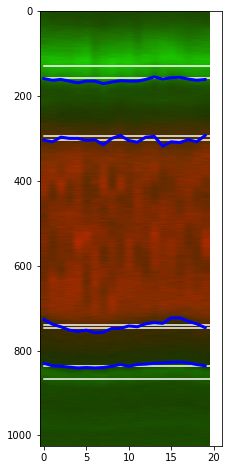

In [27]:
plt.figure(figsize=(8,8))
plt.imshow(image2DRGB[:,0:20]/300,aspect=0.05)

for label in ranges :
    plt.plot([0,20],[np.array(ranges[label])[0],np.array(ranges[label])[0]],'w')
    plt.plot([0,20],[np.array(ranges[label])[-1],np.array(ranges[label])[-1]],'w')

for label in initialtraces :
    plt.plot(np.arange(20),np.array(initialtraces[label][0:20])/dx,label=label,linewidth=3,c='b')
    
plt.savefig(outputfolder+'zones.png')

# Rigid transformation

In [28]:
channels={}

channels['red']={}
channels['green']={}
channels['mixed']={}

channels['red']['name']='red'
channels['red']['alpha']=0


channels['green']['name']='green'
channels['green']['alpha']=1

channels['mixed']['name']='mixed'
channels['mixed']['alpha']=0.6

In [29]:
def rigid_transform(fixedimage,movingimage) :
    R = sitk.ImageRegistrationMethod()

    R.SetOptimizerWeights([0,0,1,1])

    # This is more robust if intensities change
    R.SetMetricAsCorrelation()

    # I tryed several parameters here, it is robust
    R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                               minStep=1e-2,
                                               numberOfIterations=100,
                                               gradientMagnitudeTolerance=1e-4)
    R.SetOptimizerScalesFromIndexShift()


    tx = sitk.CenteredTransformInitializer(fixedimage, movingimage,sitk.Similarity2DTransform())

    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)

    #R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

    return  R.Execute(fixedimage, movingimage)

In [30]:
spantranslation={}
correctedtranslation={}
inputimage={}

windowsize=5

for channel in channels:
    # Let's try a loop over the N first frames
    nrows=4
    # pourcentage of green channel
    alpha=channels[channel]['alpha']


    inputimage[channel]=np.zeros([Nx,Ntime])
    correctedtranslation[channel]=np.zeros([Nx,Ntime])


    # template from first image
    image2Dgreen=np.array([Arraygreen[:,tini_index] for line in range(0,nrows)]).astype('float32')
    image2Dred=np.array([Arrayred[:,tini_index] for line in range(0,nrows)]).astype('float32')
    fixedimage= sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)

    correctedtranslation[channel][:,0]=sitk.GetArrayFromImage(fixedimage)[0,:]

    #create a translation object
    translation = sitk.TranslationTransform(2)

    #initialise offset
    yoffset=0

    spantranslation[channel]=[]

    for i in range(0,Ntime) :
        image2Dgreen=np.array([Arraygreen[:,tini_index+i] for line in range(0,nrows)]).astype('float32')
        image2Dred=np.array([Arrayred[:,tini_index+i] for line in range(0,nrows)]).astype('float32') 
        movingimage=sitk.GetImageFromArray(alpha*image2Dgreen+(1-alpha)*image2Dred)

        outTx = rigid_transform(fixedimage, movingimage)
        yoffset=outTx.GetParameters()[2]

        spantranslation[channel].append(yoffset)

        translation.SetParameters((yoffset,0))

        resampled = resample(movingimage, translation)

        inputimage[channel][:,i]=sitk.GetArrayFromImage(movingimage)[0,:]
        correctedtranslation[channel][:,i]=sitk.GetArrayFromImage(resampled)[0,:]

        #fixedimage=resampled  
        
        #templateimage=correctedtranslation[channel][:,0:min(windowsize,i)].mean(axis=1).astype('float32')
        #image2Dtemplate=np.array([templateimage for line in range(0,nrows)]).astype('float32')

        #fixedimage=sitk.GetImageFromArray(image2Dtemplate)

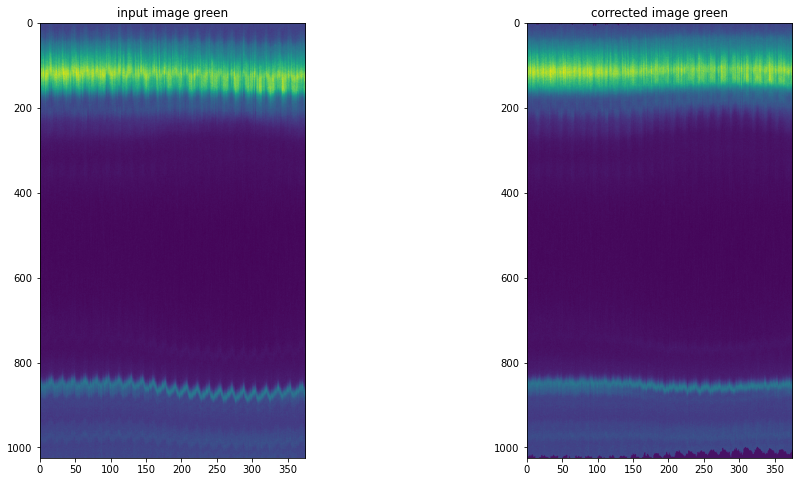

In [31]:
for channel in channels :

    plt.figure(figsize=(16,8))
    ax1=plt.subplot(121)
    ax2=plt.subplot(122)
    ax1.imshow(inputimage[channel],aspect=0.6)
    ax1.set_title('input image '+channel)
    ax2.imshow(correctedtranslation[channel],aspect=0.6)
    ax2.set_title('corrected image '+channel)
    
plt.savefig(outputfolder+'translation_correction.png')

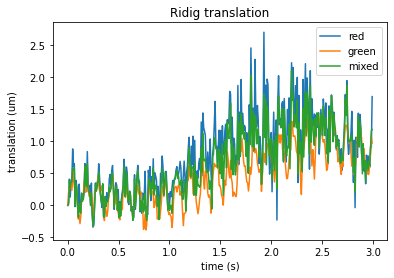

In [32]:
for channel in spantranslation :
    plt.plot(np.arange(Ntime)*ts,np.array(spantranslation[channel])*dx,label=channel)

plt.title('Ridig translation')
plt.xlabel('time (s)')
plt.ylabel('translation (um)')
plt.legend()

plt.savefig(outputfolder+'rigid motion.png')

In [33]:
import src.datanalysis as da

signal=np.array(spantranslation['mixed'])*dx
signal_filtered=savgol_filter(signal,11,3)
signal_filtered=highpassfilter(signal_filtered,fs,5)
ampl,period,tvalley,tpeak,mean=da.amp_analysis(signal,signal_filtered,np.arange(Ntime)*ts,5, 15, view=False)

In [34]:
# Lets do a bit of trigo to estimate the possible wall movement artefact due to motion
rigidmotion=np.mean(ampl) #um
vesselradius=(initialtraces['lumen_bottom']-initialtraces['lumen_top']).mean()/2 # um when contracted
endfootradius=(initialtraces['endfoot_bottom']-initialtraces['endfoot_top']).mean()/2 # um when contracted


print('Cardiac rigid motion = %e'%rigidmotion)
print('Mean vessel radius = %e'%vesselradius)

theta=np.arcsin(rigidmotion/vesselradius)
cardiacartefact=vesselradius*(1-np.cos(theta))
print('cardiac lumen artifact to be expected (radius): %.2f um'%cardiacartefact)

theta=np.arcsin(rigidmotion/endfootradius)
endfootartefact=endfootradius*(1-np.cos(theta))
print('cardiac endfoot artifact to be expected (radius): %.2f um'%endfootartefact)

pvsartefact=cardiacartefact-endfootartefact
print('cardiac PVS artifact to be expected (radius): %.2f um'%pvsartefact)
print('cardiac PVS artifact to be expected (pc): %.2f um'%(pvsartefact/(endfootradius-vesselradius)))

rigidmotion=np.max(spantranslation['mixed'])*dx-np.min(spantranslation['mixed'])*dx #um
vesselradius=(initialtraces['lumen_bottom']-initialtraces['lumen_top']).max()/2 # um



print('\nSlow waves')

print('Max rigid motion = %e'%rigidmotion)
print('Max vessel radius = %e'%vesselradius)

theta=np.arcsin(rigidmotion/vesselradius)
cardiacartefact=vesselradius*(1-np.cos(theta))
print('cardiac lumen artifact to be expected (radius): %.2f um'%cardiacartefact)

theta=np.arcsin(rigidmotion/endfootradius)
endfootartefact=endfootradius*(1-np.cos(theta))
print('cardiac endfoot artifact to be expected (radius): %.2f um'%endfootartefact)

pvsartefact=cardiacartefact-endfootartefact
print('cardiac PVS artifact to be expected (radius): %.2f um'%pvsartefact)
print('cardiac PVS artifact to be expected (pc): %.2f um'%(pvsartefact/(endfootradius-vesselradius)))

rigidmotion=np.max(spantranslation['mixed'])*dx-np.min(spantranslation['mixed'])*dx #um
vesselradius=(initialtraces['lumen_bottom']-initialtraces['lumen_top']).max()/2 # um

Cardiac rigid motion = 5.427608e-01
Mean vessel radius = 1.323694e+01
cardiac lumen artifact to be expected (radius): 0.01 um
cardiac endfoot artifact to be expected (radius): 0.01 um
cardiac PVS artifact to be expected (radius): 0.00 um
cardiac PVS artifact to be expected (pc): 0.00 um

Slow waves
Max rigid motion = 2.441816e+00
Max vessel radius = 1.477613e+01
cardiac lumen artifact to be expected (radius): 0.20 um
cardiac endfoot artifact to be expected (radius): 0.16 um
cardiac PVS artifact to be expected (radius): 0.04 um
cardiac PVS artifact to be expected (pc): 0.01 um


# Non-rigid deformation

In [35]:
margin=20
correctedtranslationcrop={}
for channel in channels :
    correctedtranslationcrop[channel]=correctedtranslation[channel][margin:-margin,:]

In [36]:
np.shape(correctedtranslationcrop[channel])

(985, 375)

In [37]:
def smooth_and_resample(image, shrink_factors, smoothing_sigmas):
    """
    Args:
        image: The image we want to resample.
        shrink_factor(s): Number(s) greater than one, such that the new image's size is original_size/shrink_factor.
        smoothing_sigma(s): Sigma(s) for Gaussian smoothing, this is in physical units, not pixels.
    Return:
        Image which is a result of smoothing the input and then resampling it using the given sigma(s) and shrink factor(s).
    """
    if np.isscalar(shrink_factors):
        shrink_factors = [shrink_factors]*image.GetDimension()
    if np.isscalar(smoothing_sigmas):
        smoothing_sigmas = [smoothing_sigmas]*image.GetDimension()

    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigmas)
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(sz/float(sf) + 0.5) for sf,sz in zip(shrink_factors,original_size)]
    new_spacing = [((original_sz-1)*original_spc)/(new_sz-1) 
                   for original_sz, original_spc, new_sz in zip(original_size, original_spacing, new_size)]
    return sitk.Resample(smoothed_image, new_size, sitk.Transform(), 
                         sitk.sitkLinear, image.GetOrigin(),
                         new_spacing, image.GetDirection(), 0.0, 
                         image.GetPixelID())


    
def multiscale_demons(registration_algorithm,
                      fixed_image, moving_image, initial_transform = None, 
                      shrink_factors=None, smoothing_sigmas=None, output=False):
    """
    Run the given registration algorithm in a multiscale fashion. The original scale should not be given as input as the
    original images are implicitly incorporated as the base of the pyramid.
    Args:
        registration_algorithm: Any registration algorithm that has an Execute(fixed_image, moving_image, displacement_field_image)
                                method.
        fixed_image: Resulting transformation maps points from this image's spatial domain to the moving image spatial domain.
        moving_image: Resulting transformation maps points from the fixed_image's spatial domain to this image's spatial domain.
        initial_transform: Any SimpleITK transform, used to initialize the displacement field.
        shrink_factors (list of lists or scalars): Shrink factors relative to the original image's size. When the list entry, 
                                                   shrink_factors[i], is a scalar the same factor is applied to all axes.
                                                   When the list entry is a list, shrink_factors[i][j] is applied to axis j.
                                                   This allows us to specify different shrink factors per axis. This is useful
                                                   in the context of microscopy images where it is not uncommon to have
                                                   unbalanced sampling such as a 512x512x8 image. In this case we would only want to 
                                                   sample in the x,y axes and leave the z axis as is: [[[8,8,1],[4,4,1],[2,2,1]].
        smoothing_sigmas (list of lists or scalars): Amount of smoothing which is done prior to resmapling the image using the given shrink factor. These
                          are in physical (image spacing) units.
    Returns: 
        SimpleITK.DisplacementFieldTransform
    """
    # Create image pyramid.
    fixed_images = [fixed_image]
    moving_images = [moving_image]
    if shrink_factors:
        for shrink_factor, smoothing_sigma in reversed(list(zip(shrink_factors, smoothing_sigmas))):
            fixed_images.append(smooth_and_resample(fixed_images[0], shrink_factor, smoothing_sigma))
            moving_images.append(smooth_and_resample(moving_images[0], shrink_factor, smoothing_sigma))
    
    # Create initial displacement field at lowest resolution. 
    # Currently, the pixel type is required to be sitkVectorFloat64 because of a constraint imposed by the Demons filters.
    if initial_transform:
        initial_displacement_field = sitk.TransformToDisplacementField(initial_transform, 
                                                                       sitk.sitkVectorFloat64,
                                                                       fixed_images[-1].GetSize(),
                                                                       fixed_images[-1].GetOrigin(),
                                                                       fixed_images[-1].GetSpacing(),
                                                                       fixed_images[-1].GetDirection())

        
    else:
        #initial_displacement_field = sitk.Image(fixed_images[-1].GetWidth(), 
        #                                        fixed_images[-1].GetHeight(),
        #                                        fixed_images[-1].GetDepth(),
        #                                        sitk.sitkVectorFloat64)
        
        #initial_displacement_field.CopyInformation(fixed_images[-1])
        initial_displacement_field = registration_algorithm.Execute(fixed_images[-1],moving_images[-1])

 
    # Run the registration.
    initial_displacement_field = registration_algorithm.Execute(fixed_images[-1],moving_images[-1],initial_displacement_field)
        
    # Start at the top of the pyramid and work our way down.    
    for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
            initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
            initial_displacement_field = registration_algorithm.Execute(f_image, m_image, initial_displacement_field)
    
    
    
    return sitk.DisplacementFieldTransform(initial_displacement_field)

In [40]:
# Select a Demons filter and configure it.
#demons_filter =  sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons_filter= sitk.DiffeomorphicDemonsRegistrationFilter()
#demons_filter= sitk.SymmetricForcesDemonsRegistrationFilter
#DemonsRegistrationFilter
#DiffeomorphicDemonsRegistrationFilter
#demons_filter= FastSymmetricForcesDemonsRegistrationFilter
#SymmetricForcesDemonsRegistrationFilter


demons_filter.SetNumberOfIterations(NumberOfIterations=100)

# Regularization (update field - viscous, total field - elastic).
#demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(1.0)


In [41]:
# template from first image
image2D=np.array([correctedtranslationcrop[channel][:,0] for line in range(0,nrows)]).astype('float32')
fixedimage_index= sitk.GetImageFromArray(image2D)

image2D=np.array([correctedtranslationcrop[channel][:,-1] for line in range(0,nrows)]).astype('float32')
movingimage_index= sitk.GetImageFromArray(image2D)

# Run the registration.
tx = multiscale_demons(registration_algorithm=demons_filter, 
                       fixed_image = fixedimage_index, 
                       moving_image = movingimage_index,
                       shrink_factors = [2],
                       smoothing_sigmas = [8,4],
                       output=True)

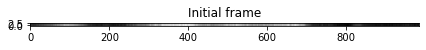

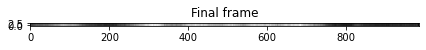

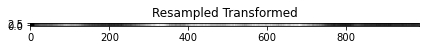

In [42]:
myshow(fixedimage_index, 'Initial frame')
myshow(movingimage_index, 'Final frame')
resampled = resample(movingimage_index, tx)
myshow(resampled, 'Resampled Transformed')

In [43]:
channels_selection=['mixed']

In [44]:
Ntime

375

In [48]:
windowsize=1

deformations={}
correctedimage={}
deformationimage={}



for channel in channels_selection :
    
    print(channel)
    
    deformations[channel]={}

    for label in ranges :
        deformations[channel][label]=[]

    for label in ranges :
            deformations[channel][label].append(0.)
            
    # the reference template will be an average of windowsize frames

    correctedimage[channel]=np.zeros((Nx-2*margin,Ntime))
    deformationimage[channel]=np.zeros((Nx-2*margin,Ntime))

    # template from first image
    image2D=np.array([correctedtranslationcrop[channel][:,0] for line in range(0,nrows)]).astype('float32')
    fixedimage= sitk.GetImageFromArray(image2D)
    correctedimage[channel][:,0]=sitk.GetArrayFromImage(fixedimage)[0,:]


    for i in range(1,Ntime) :
        if (i%10)==0:
            print('process '+ channel +' channel, %.1f pc '%(i/Ntime*100))
        image2D=np.array([correctedtranslationcrop[channel][:,i] for line in range(0,nrows)]).astype('float32')
        movingimage= sitk.GetImageFromArray(image2D)

        outTx = multiscale_demons(registration_algorithm=demons_filter, 
                           fixed_image = fixedimage, 
                           moving_image = movingimage,
                           shrink_factors = [2],
                           smoothing_sigmas = [8,4])

        resampled = resample(movingimage, outTx)

        correctedimage[channel][:,i]=sitk.GetArrayFromImage(resampled).mean(axis=0)


        U,V=get_deformation(fixedimage, outTx)

        for label in ranges :
            deformations[channel][label].append(U[0,np.array(ranges[label])-margin].mean())

        deformationimage[channel][:,i]=U.mean(axis=0)

        #templateimage=correctedimage[:,max(i-windowsize,0):i].mean(axis=1).astype('float32') 
        i0=max(i-100,0)
        i0=0
        templateimage=correctedimage[channel][:,i0:i0+min(windowsize,i)].mean(axis=1).astype('float32')
        image2Dtemplate=np.array([templateimage for line in range(0,nrows)]).astype('float32')

        fixedimage=sitk.GetImageFromArray(image2Dtemplate)

mixed
process mixed channel, 2.7 pc 
process mixed channel, 5.3 pc 
process mixed channel, 8.0 pc 
process mixed channel, 10.7 pc 
process mixed channel, 13.3 pc 
process mixed channel, 16.0 pc 
process mixed channel, 18.7 pc 
process mixed channel, 21.3 pc 
process mixed channel, 24.0 pc 
process mixed channel, 26.7 pc 
process mixed channel, 29.3 pc 
process mixed channel, 32.0 pc 
process mixed channel, 34.7 pc 
process mixed channel, 37.3 pc 
process mixed channel, 40.0 pc 
process mixed channel, 42.7 pc 
process mixed channel, 45.3 pc 
process mixed channel, 48.0 pc 
process mixed channel, 50.7 pc 
process mixed channel, 53.3 pc 
process mixed channel, 56.0 pc 
process mixed channel, 58.7 pc 
process mixed channel, 61.3 pc 
process mixed channel, 64.0 pc 
process mixed channel, 66.7 pc 
process mixed channel, 69.3 pc 
process mixed channel, 72.0 pc 
process mixed channel, 74.7 pc 
process mixed channel, 77.3 pc 
process mixed channel, 80.0 pc 
process mixed channel, 82.7 pc 
proce

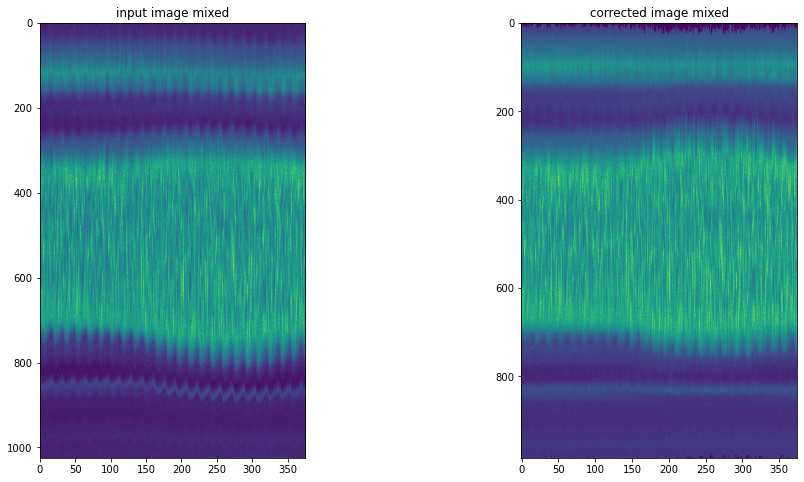

In [51]:
for channel in channels_selection :
    plt.figure(figsize=(16,8))
    ax1=plt.subplot(121)
    ax2=plt.subplot(122)
    ax1.imshow(inputimage[channel],aspect=0.6)
    ax1.set_title('input image '+channel)
    ax2.imshow(correctedimage[channel],aspect=0.6)
    ax2.set_title('corrected image '+channel)

plt.savefig(outputfolder+'deformation_correction.png')
#for label in ranges :
#    plt.plot([0,Ntime],[np.array(ranges[label])[0]-margin,np.array(ranges[label])[0]-margin],'r')
#    plt.plot([0,Ntime],[np.array(ranges[label])[-1]-margin,np.array(ranges[label])[-1]-margin],'r')

/tmp/ipykernel_11891/1397904138.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_mesh,y_mesh,velocityimage,cmap=CM.jet,vmin=-0.1,vmax=0.1)


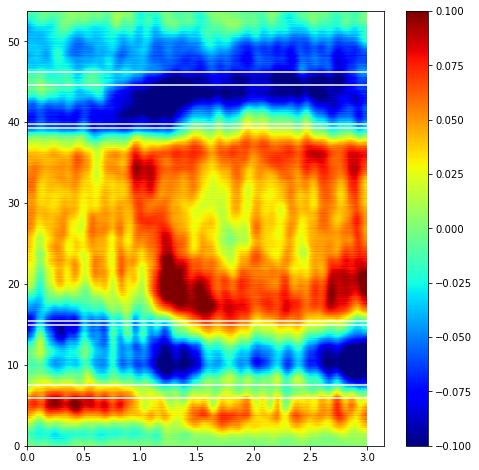

In [50]:
from matplotlib import cm as CM
from scipy import ndimage

for channel in channels_selection:

    # smooth deformations
    deformationimage_smooth=ndimage.gaussian_filter(deformationimage[channel], (0, 5))

    velocityimage=np.diff(deformationimage_smooth,axis=0)

    x_grid=np.arange(0,Ntime)*ts
    y_grid=np.arange(0,Nx-margin*2)*dx
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)

    plt.figure(figsize=(8,8))
    plt.pcolormesh(x_mesh,y_mesh,velocityimage,cmap=CM.jet,vmin=-0.1,vmax=0.1)

    plt.colorbar()
    for label in ranges :
        plt.plot([0,Ntime*ts],[(np.array(ranges[label])[0]-margin)*dx,(np.array(ranges[label])[0]-margin)*dx],'w')
        plt.plot([0,Ntime*ts],[(np.array(ranges[label])[-1]-margin)*dx,(np.array(ranges[label])[-1]-margin)*dx],'w')

# Methods comparisons

In [251]:
def extract_diameter(scanline,initialtraces,deformations) :
    
    cutoff=25
    
    bottom=np.array(initialtraces[scanline+'_bottom'])
    top=np.array(initialtraces[scanline+'_top'])


    diameter=bottom-top
    
    #diameter_th=lowpassfilter(diameter,fs,cutoff)
    top_th=savgol_filter(top,11,3)
    bottom_th=savgol_filter(bottom,11,3)
    
    bottom=np.array(deformations[scanline+'_bottom'])*dx+np.array(initialtraces[scanline+'_bottom'])[0]
    top=np.array(deformations[scanline+'_top'])*dx+np.array(initialtraces[scanline+'_top'])[0]


    diameter=bottom-top
    
    #diameter_reg=lowpassfilter(diameter,fs,cutoff)
    top_reg=savgol_filter(top,11,3)
    bottom_reg=savgol_filter(bottom,11,3)

    
    return (top_th,bottom_th,top_reg,bottom_reg)

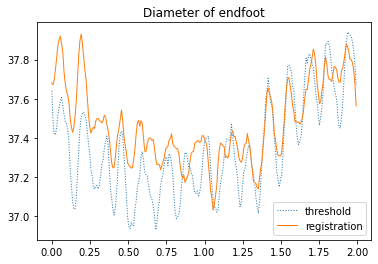

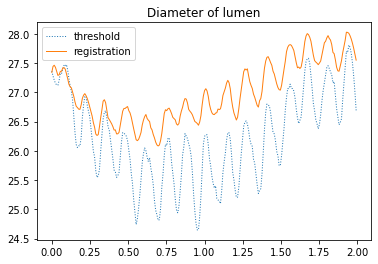

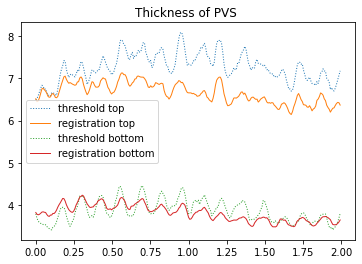

In [252]:
channellumen='mixed'
channelendfoot='mixed'

endfoot_top_th,endfoot_bottom_th,endfoot_top_reg,endfoot_bottom_reg=extract_diameter('endfoot',initialtraces,deformations[channelendfoot])
endfoot_th=-(endfoot_top_th-endfoot_bottom_th)
endfoot_reg=-(endfoot_top_reg-endfoot_bottom_reg)

lumen_top_th,lumen_bottom_th,lumen_top_reg,lumen_bottom_reg=extract_diameter('lumen',initialtraces,deformations[channellumen])
lumen_th=-(lumen_top_th-lumen_bottom_th)
lumen_reg=-(lumen_top_reg-lumen_bottom_reg)

pvs_top_th=lumen_top_th-endfoot_top_th
pvs_top_reg=lumen_top_reg-endfoot_top_reg

pvs_bottom_th=-(lumen_bottom_th-endfoot_bottom_th)
pvs_bottom_reg=-(lumen_bottom_reg-endfoot_bottom_reg)
                


plt.figure()
plt.plot(np.arange(Ntime)*ts,endfoot_th,':',label='threshold',linewidth=1)
plt.plot(np.arange(Ntime)*ts,endfoot_reg,label='registration',linewidth=1)
plt.title('Diameter of endfoot')
plt.legend()

plt.figure()
plt.plot(np.arange(Ntime)*ts,lumen_th,':',label='threshold',linewidth=1)
plt.plot(np.arange(Ntime)*ts,lumen_reg,label='registration',linewidth=1)
plt.title('Diameter of lumen')
plt.legend()

plt.figure()
plt.plot(np.arange(Ntime)*ts,pvs_top_th,':',label='threshold top',linewidth=1)
plt.plot(np.arange(Ntime)*ts,pvs_top_reg,label='registration top',linewidth=1)

plt.plot(np.arange(Ntime)*ts,pvs_bottom_th,':',label='threshold bottom',linewidth=1)
plt.plot(np.arange(Ntime)*ts,pvs_bottom_reg,label='registration bottom',linewidth=1)
plt.title('Thickness of PVS ')
plt.legend()


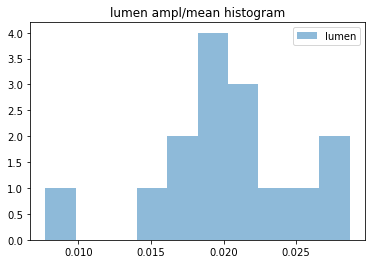

In [294]:
signal=lumen_reg
#signal_filtered=savgol_filter(signal,11,3)
signal_filtered=highpassfilter(signal,fs,5)
ampl_lumen,period_lumen,tvalley_lumen,tpeak_lumen,mean_lumen=da.amp_analysis(signal,signal_filtered,np.arange(Ntime)*ts,5, 15, view=False)

plt.hist(ampl_lumen/mean_lumen,label='lumen',alpha=0.5)
plt.title('lumen ampl/mean histogram')
plt.legend()

plt.savefig(outputfolder+'ampl_lumen.png')




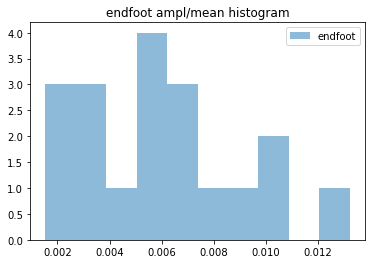

In [297]:
signal=endfoot_reg
#signal_filtered=savgol_filter(signal,11,3)
signal_filtered=highpassfilter(signal,fs,5)
ampl_endfoot,period_endfoot,tvalley_endfoot,tpeak_endfoot,mean_endfoot=da.amp_analysis(signal,signal_filtered,np.arange(Ntime)*ts,5, 15, view=False)

plt.hist(ampl_endfoot/mean_endfoot,label='endfoot',alpha=0.5)
plt.title('endfoot ampl/mean histogram')
plt.legend()

plt.savefig(outputfolder+'ampl_endfoot.png')

        corrr       amp
39   0.278887  0.242772
40   0.302092  0.235945
41   0.075693  0.225499
42   0.350999  0.207503
43   0.211627  0.162575
173  0.213218  0.503350
174  0.296893  0.295032
175  0.375098  0.389522
176  0.319550  0.594565
177  0.330506  0.319646
178 -0.212665  0.436344
179 -0.146360  0.849130
180  0.334716  0.466532
181  0.134582  0.684968
182  0.141824  0.597925
183  0.581463  0.229853
184  0.312974  0.227824
185  0.289597  0.626250
186  0.052223  0.373087
187  0.144156  0.478531


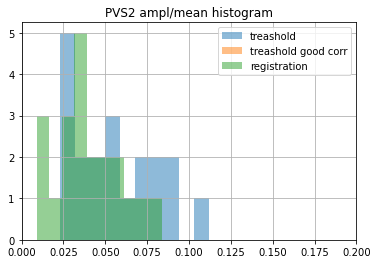

In [269]:
signal=pvs_top_reg
#signal_filtered=savgol_filter(signal,11,3)
signal_filtered=highpassfilter(signal,fs,5)
ampl_top,period_top,tvalley_top,tpeak_top,mean_top=da.amp_analysis(signal,signal_filtered,np.arange(Ntime)*ts,5, 15, view=False)

filter=peaktopeakPVS2['bandname']=='cardiac'
filter=(peaktopeakPVS2['tmin']>tini)&(peaktopeakPVS2['tmin']<tini+timewindow)
(peaktopeakPVS2['amp'][filter]/peaktopeakPVS2['mean'][filter]).hist(label='treashold',alpha=0.5)

print(peaktopeakPVS2[['corrr','amp']][filter])

filter=filter&(peaktopeakPVS2['corrr']>0.90)
(peaktopeakPVS2['amp'][filter]/peaktopeakPVS2['mean'][filter]).hist(label='treashold good corr',alpha=0.5)

plt.hist(ampl_top/mean_top,label='registration',alpha=0.5)
plt.xlim([0,0.2])
plt.title('PVS2 ampl/mean histogram')
plt.legend()

plt.savefig(outputfolder+'ampl_PVS2.png')

        corrr       amp  periodvar    ampvar  slopevar  tortuosity    rawvar  \
36   0.937346  0.161791        NaN       NaN       NaN    4.891976  0.207608   
37   0.903474  0.083100        NaN       NaN       NaN    3.623241  0.158873   
38   0.950186  0.061450        NaN       NaN       NaN    2.918672  0.142780   
39   0.954556  0.143302        NaN       NaN       NaN    2.516756  0.110930   
141  0.955792  0.384350   0.208883  0.018001  3.080196    1.103684  0.184839   
142  0.938749  0.558871   0.198941  0.011657  2.799221    1.215774  0.200168   
143  0.934568  0.515292   0.153437  0.007230  2.121138    1.147258  0.198806   
144  0.948262  0.659967   0.096440  0.005112  1.582177    1.499135  0.254164   
145  0.927402  0.667528   0.092117  0.009426  1.983361    1.445363  0.248085   
146  0.912067  0.528189   0.107962  0.011879  1.970896    1.061794  0.183273   
147  0.957692  0.444169   0.118136  0.012729  2.169946    1.214949  0.189164   
148  0.874188  0.404152   0.096623  0.01

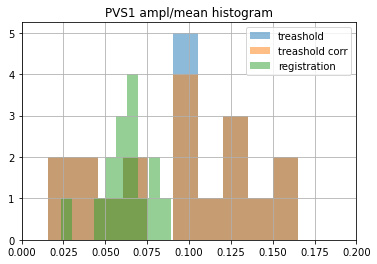

In [270]:
signal=pvs_bottom_reg
#signal_filtered=savgol_filter(signal,11,3)
signal_filtered=highpassfilter(signal,fs,5)
ampl_bottom,period_bottom,tvalley_bottom,tpeak_bottom,mean_bottom=da.amp_analysis(signal,signal_filtered,np.arange(Ntime)*ts,5, 15, view=False)
filter=peaktopeakPVS1['bandname']=='cardiac'
filter=(peaktopeakPVS1['tmin']>tini)&(peaktopeakPVS1['tmin']<tini+timewindow)
(peaktopeakPVS1['amp'][filter]/peaktopeakPVS1['mean'][filter]).hist(label='treashold',alpha=0.5)
print(peaktopeakPVS1[['corrr','amp','periodvar', 'ampvar','slopevar', 'tortuosity', 'rawvar', 'outlier']][filter])

filter=filter&(peaktopeakPVS1['corrr']>0.9)
#filter=filter&(peaktopeakPVS1['tortuosity']<1)
(peaktopeakPVS1['amp'][filter]/peaktopeakPVS1['mean'][filter]).hist(label='treashold corr',alpha=0.5)

plt.xlim([0,0.2])
#peaktopeakPVS1[['corrr','amp']][filter]
plt.hist(ampl_bottom/mean_bottom,label='registration',alpha=0.5)
 
plt.title('PVS1 ampl/mean histogram')
plt.legend()

plt.savefig(outputfolder+'ampl_PVS1.png')

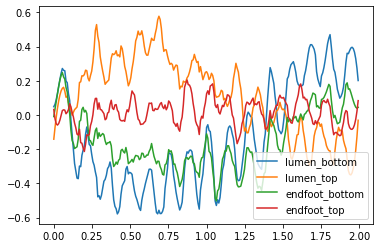

In [255]:
for label in ['lumen_bottom','lumen_top'] :
    plt.plot(np.arange(len(deformations[channellumen][label]))*ts,savgol_filter(np.array(deformations[channellumen][label])*dx,15,3),label=label)
    

for label in ['endfoot_bottom','endfoot_top'] :
    plt.plot(np.arange(len(deformations[channelendfoot][label]))*ts,savgol_filter(np.array(deformations[channelendfoot][label])*dx,15,3),label=label)
    
plt.legend()

In [298]:
from scipy.stats import pearsonr

trace1=highpassfilter(lumen_bottom_reg,fs,5)
trace2=highpassfilter(endfoot_bottom_reg,fs,5)

corrpvs_bottom,_=pearsonr(trace1,trace2)

trace1=highpassfilter(lumen_top_reg,fs,5)
trace2=highpassfilter(endfoot_top_reg,fs,5)

corrpvs_top,_=pearsonr(trace1,trace2)


trace1=highpassfilter(lumen_top_reg,fs,5)
trace2=highpassfilter(lumen_bottom_reg,fs,5)

corr_lumen,_=pearsonr(trace1,trace2)

trace1=highpassfilter(endfoot_top_reg,fs,5)
trace2=highpassfilter(endfoot_bottom_reg,fs,5)

corr_endfoot,_=pearsonr(trace1,trace2)



In [331]:
toprint=[]

toprint.append(Files[mouse]['name'])
toprint.append(tini)
toprint.append(timewindow)

l=(mean_lumen.mean(),mean_lumen.std(),ampl_lumen.mean(),ampl_lumen.std(),ampl_lumen.mean()/mean_lumen.mean(),corr_lumen)
[toprint.append(element) for element in l]
print('mean lumen, std lumen, amp lumen, std lumen, ratio mean, corr')
print('%e, %e, %e, %e, %e, %e'%l)

l=(mean_endfoot.mean(),mean_endfoot.std(),ampl_endfoot.mean(),ampl_endfoot.std(),ampl_endfoot.mean()/mean_endfoot.mean(),corr_endfoot)
[toprint.append(element) for element in l]

print('mean endfoot, std endfoot, amp endfoot, std endfoot, ratio mean, corr')
print('%e, %e, %e, %e, %e, %e'%l)

l=(mean_bottom.mean(),mean_bottom.std(),ampl_bottom.mean(),ampl_bottom.std(),ampl_bottom.mean()/mean_bottom.mean(),corrpvs_bottom)
[toprint.append(element) for element in l]
print('mean PVS1, std PVS1, amp PVS1, std PVS1, ratio mean, corr')
print('%e, %e, %e, %e, %e, %e'%l)
      
      
l=(mean_top.mean(),mean_top.std(),ampl_top.mean(),ampl_top.std(),ampl_top.mean()/mean_top.mean(),corrpvs_top)
[toprint.append(element) for element in l]

print('mean PVS2, std PVS2, amp PVS2, std PVS2, ratio mean, corr')
print('%e, %e, %e, %e, %e, %e'%l)

l=(ampl.mean(),ampl.std(),(np.max(spantranslation['mixed'])*dx-np.min(spantranslation['mixed'])*dx))
[toprint.append(element) for element in l]
print(' amp card rigid, std rigid, max rigid')
print('%e, %e, %e'%l)

mean lumen, std lumen, amp lumen, std lumen, ratio mean, corr
2.699683e+01, 4.738992e-01, 5.383720e-01, 1.307336e-01, 1.994205e-02, -3.283960e-01
mean endfoot, std endfoot, amp endfoot, std endfoot, ratio mean, corr
3.746192e+01, 1.758614e-01, 2.243342e-01, 1.133177e-01, 5.988326e-03, 3.585650e-01
mean PVS1, std PVS1, amp PVS1, std PVS1, ratio mean, corr
3.804440e+00, 1.658859e-01, 2.402115e-01, 6.282450e-02, 6.313977e-02, 8.002217e-01
mean PVS2, std PVS2, amp PVS2, std PVS2, ratio mean, corr
6.647158e+00, 2.097740e-01, 2.696502e-01, 1.297441e-01, 4.056623e-02, 1.870259e-01
 amp card rigid, std rigid, max rigid
5.460892e-01, 1.139704e-01, 1.511169e+00


In [338]:
file='results.csv'
import csv   

with open(file, 'a') as f:
    writer = csv.writer(f)
    writer.writerow(toprint)